In [1]:
# Скопируем проект по ссылке в локальную среду выполнения
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project.git

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93
Receiving objects: 100% (96/96), 33.99 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
# Сменим директорию исполнения на вновь созданную папку "EEL6812_DeepFool_Project" проекта
%cd /content/EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


In [3]:
# Выполним импорт библиотек
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision  import datasets, models
from torchvision.transforms import transforms

In [4]:
# Выполним импорт вспомогательных библиотек из локальных файлов проекта
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

In [5]:
# Установим случайное рандомное значение в виде переменной rand_seed для варианта 10
rand_seed = 10

# Установим указанное значение для np.random.seed и torch.manual_seed
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [6]:
# Используем в качестсве устройства видеокарту
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [7]:
# Загрузим датасет MNIST c параметрами mnist_mean = 0.5, mnist_std = 0.5, mnist_dim = 28
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)

mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])

mnist_tf_train = transforms.Compose([ transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])

mnist_tf_inv = transforms.Compose([ transforms.Normalize( mean=0.0, std=np.divide(1.0, mnist_std)), transforms.Normalize( mean=np.multiply(-1.0, mnist_std), std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

100%|██████████| 9912422/9912422 [00:00<00:00, 190126449.62it/s]

Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39821069.63it/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75522434.28it/s]

Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21821911.53it/s]


Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



In [8]:
# Загрузим датасет CIFAR-10 c параметрами cifar_mean = [0.491, 0.482, 0.447] cifar_std = [0.202, 0.199, 0.201] cifar_dim = 32
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)

cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean=cifar_mean, std=cifar_std)])

cifar_tf_train = transforms.Compose([ transforms.RandomCrop( size=cifar_dim, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=cifar_mean, std=cifar_std)])

cifar_tf_inv = transforms.Compose([ transforms.Normalize( mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)), transforms.Normalize( mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)

cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:05<00:00, 29134501.88it/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


In [9]:
# Выполним настройку и загрузку DataLoader batch_size = 64 workers = 4
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# Настроим параметры для обучения
batch_size = 10
num_classes = 10
overshoot = 0.02
max_iters = 50
deep_args = [batch_size, num_classes, overshoot, max_iters]

In [12]:
# Загрузим и оценим стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))

evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


In [13]:
# Загрузим и оценим стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))

evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


Выполним оценку атакующих примеров для сетей:

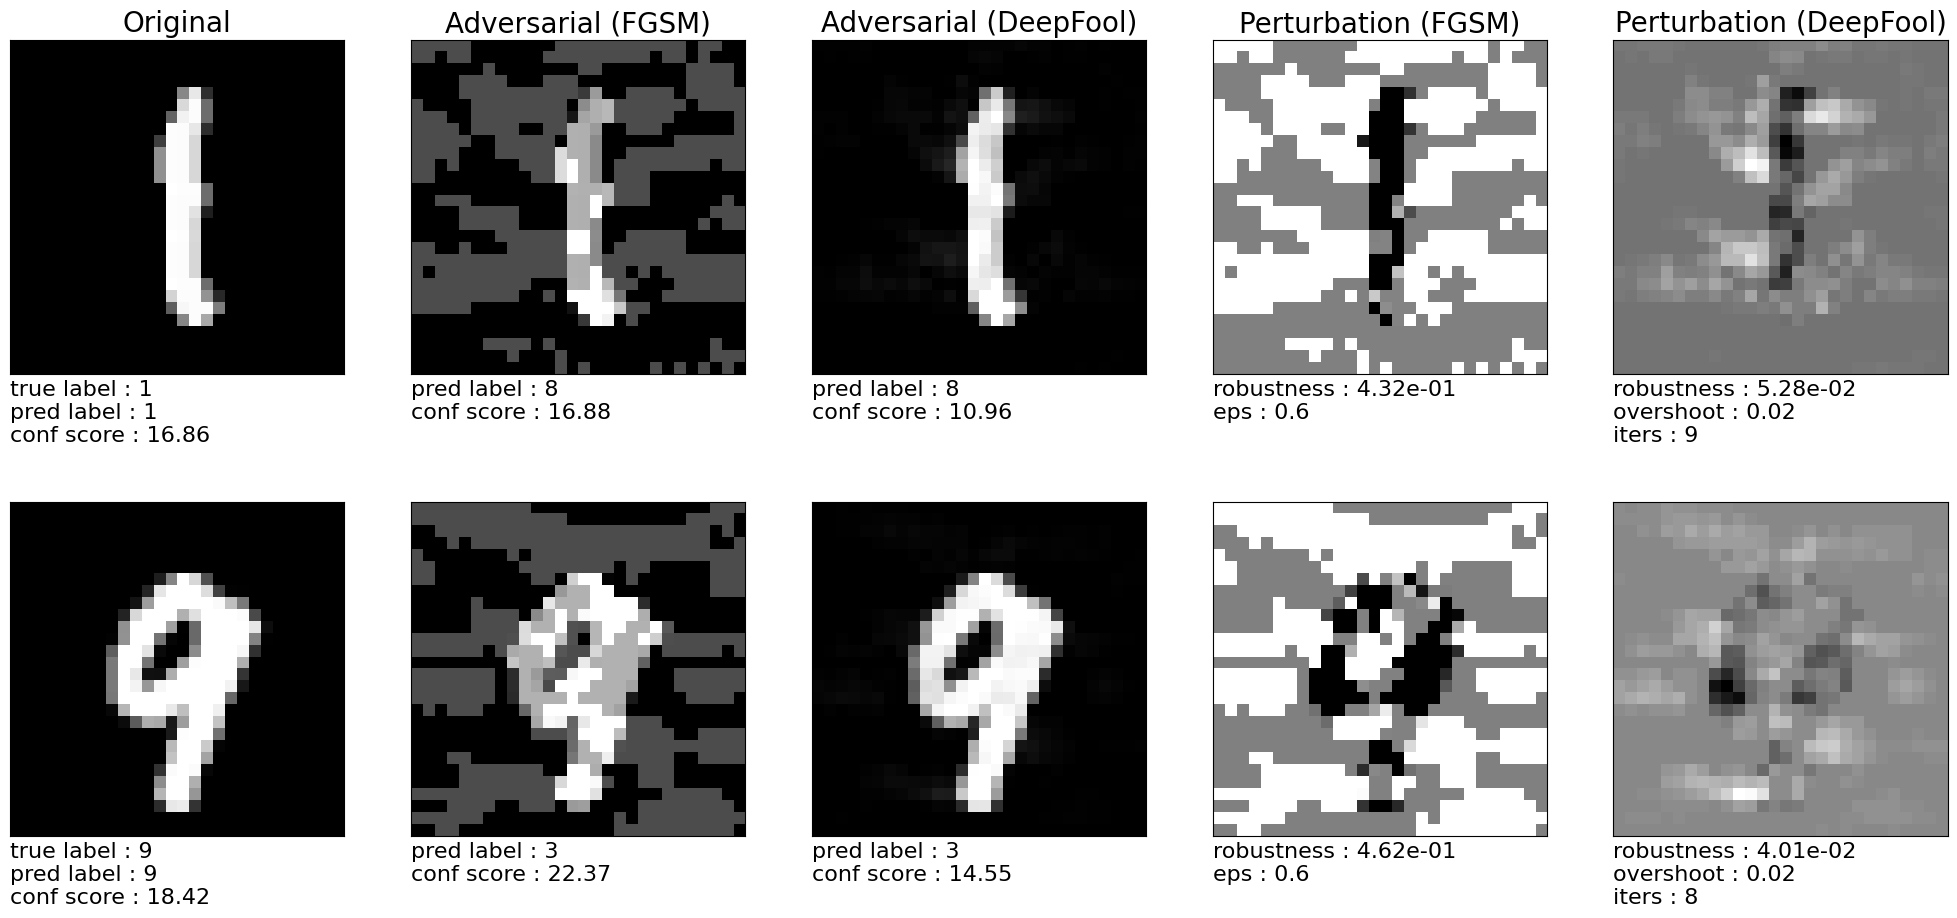

In [21]:
# LeNet на MNIST
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth', map_location=device))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

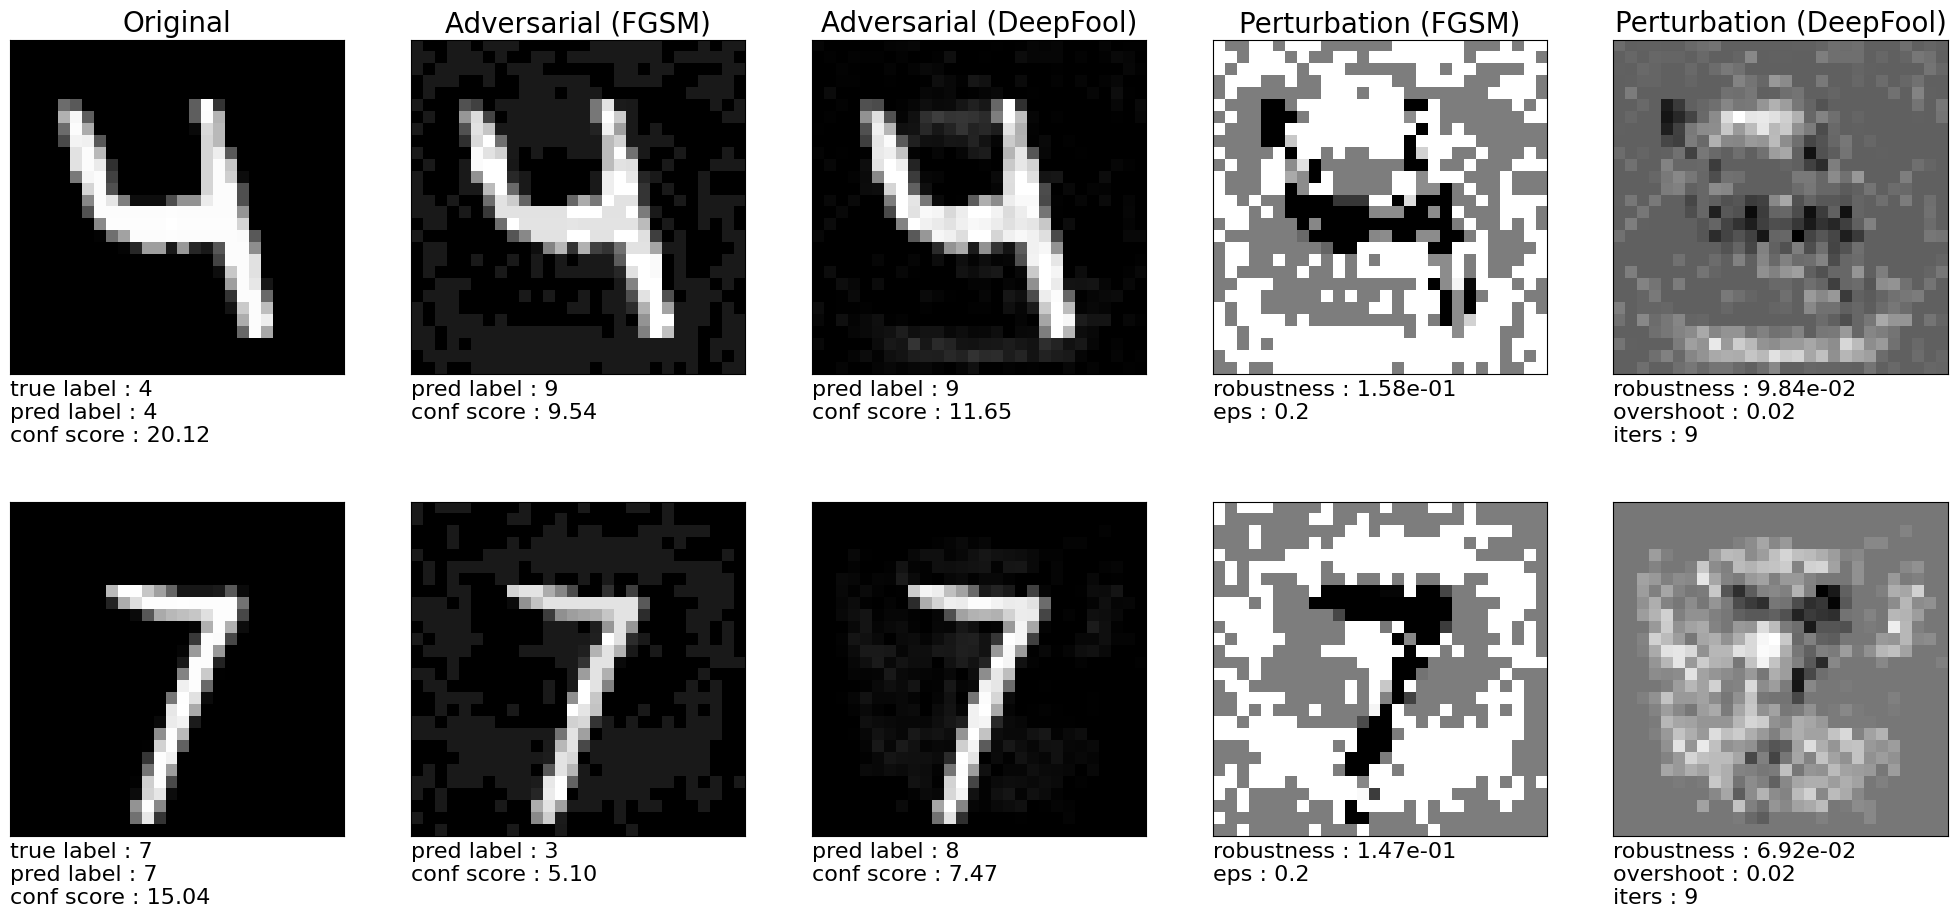

In [22]:
# FCNet на MNIST
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()

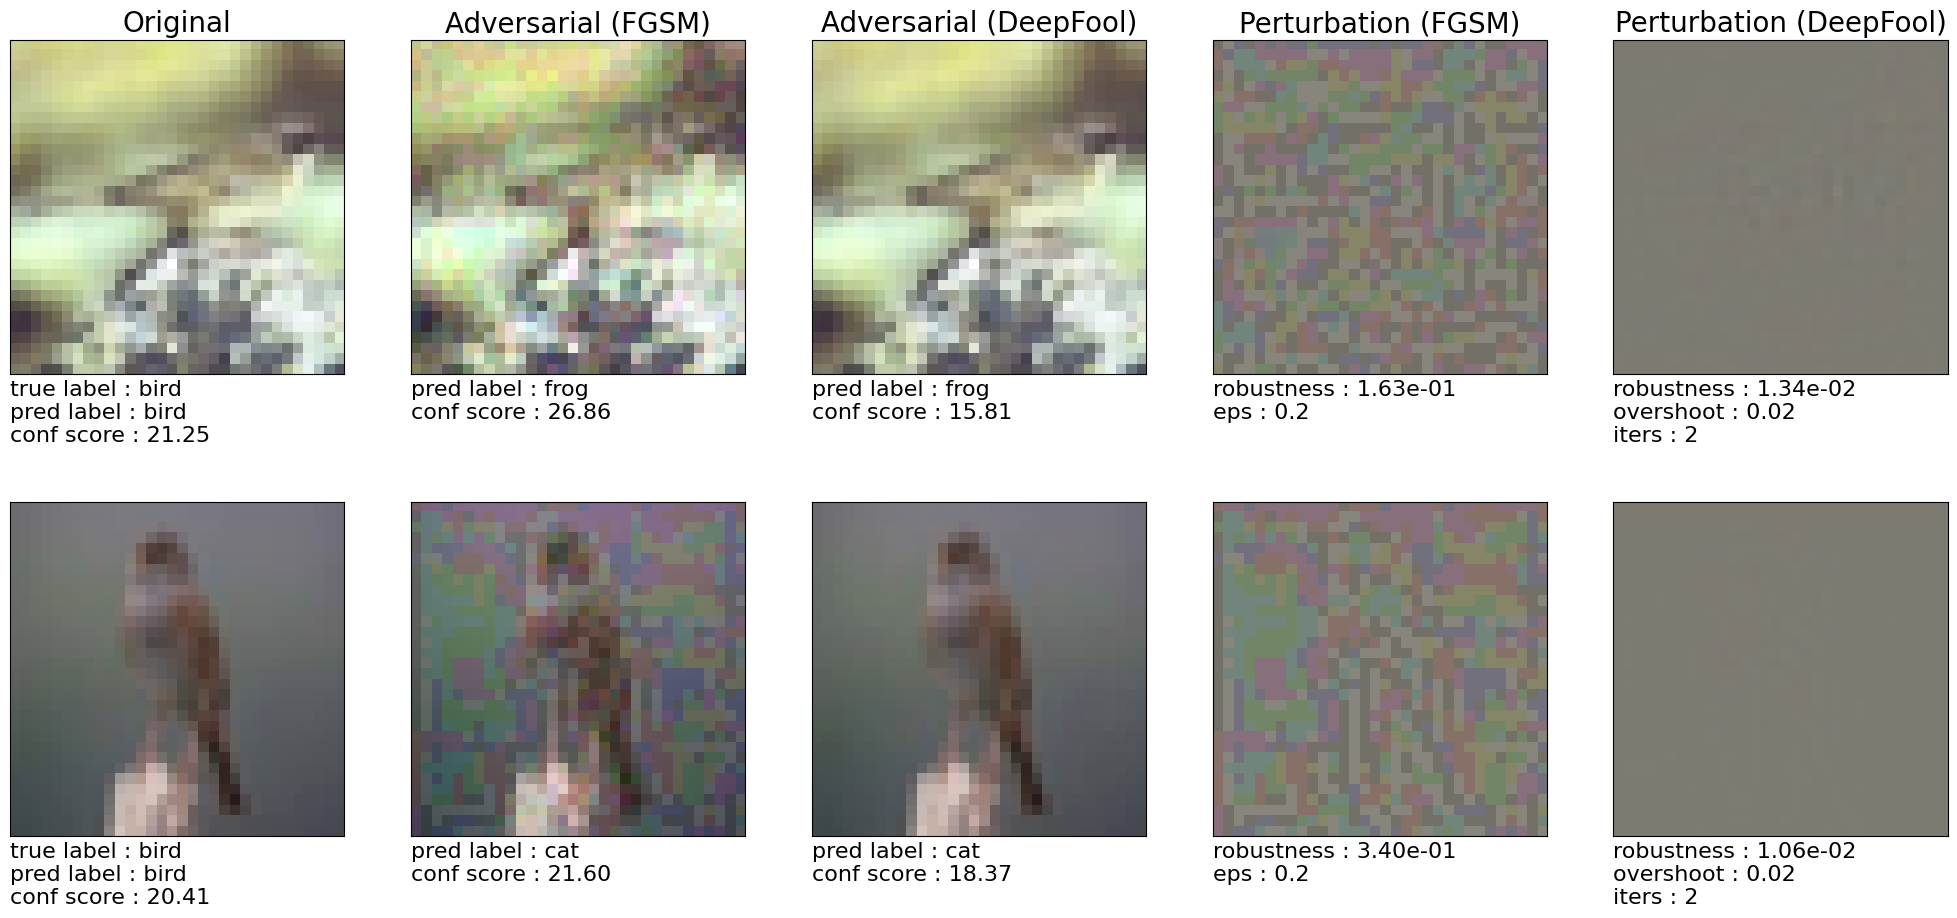

In [23]:
# Network-in-Network на CIFAR
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

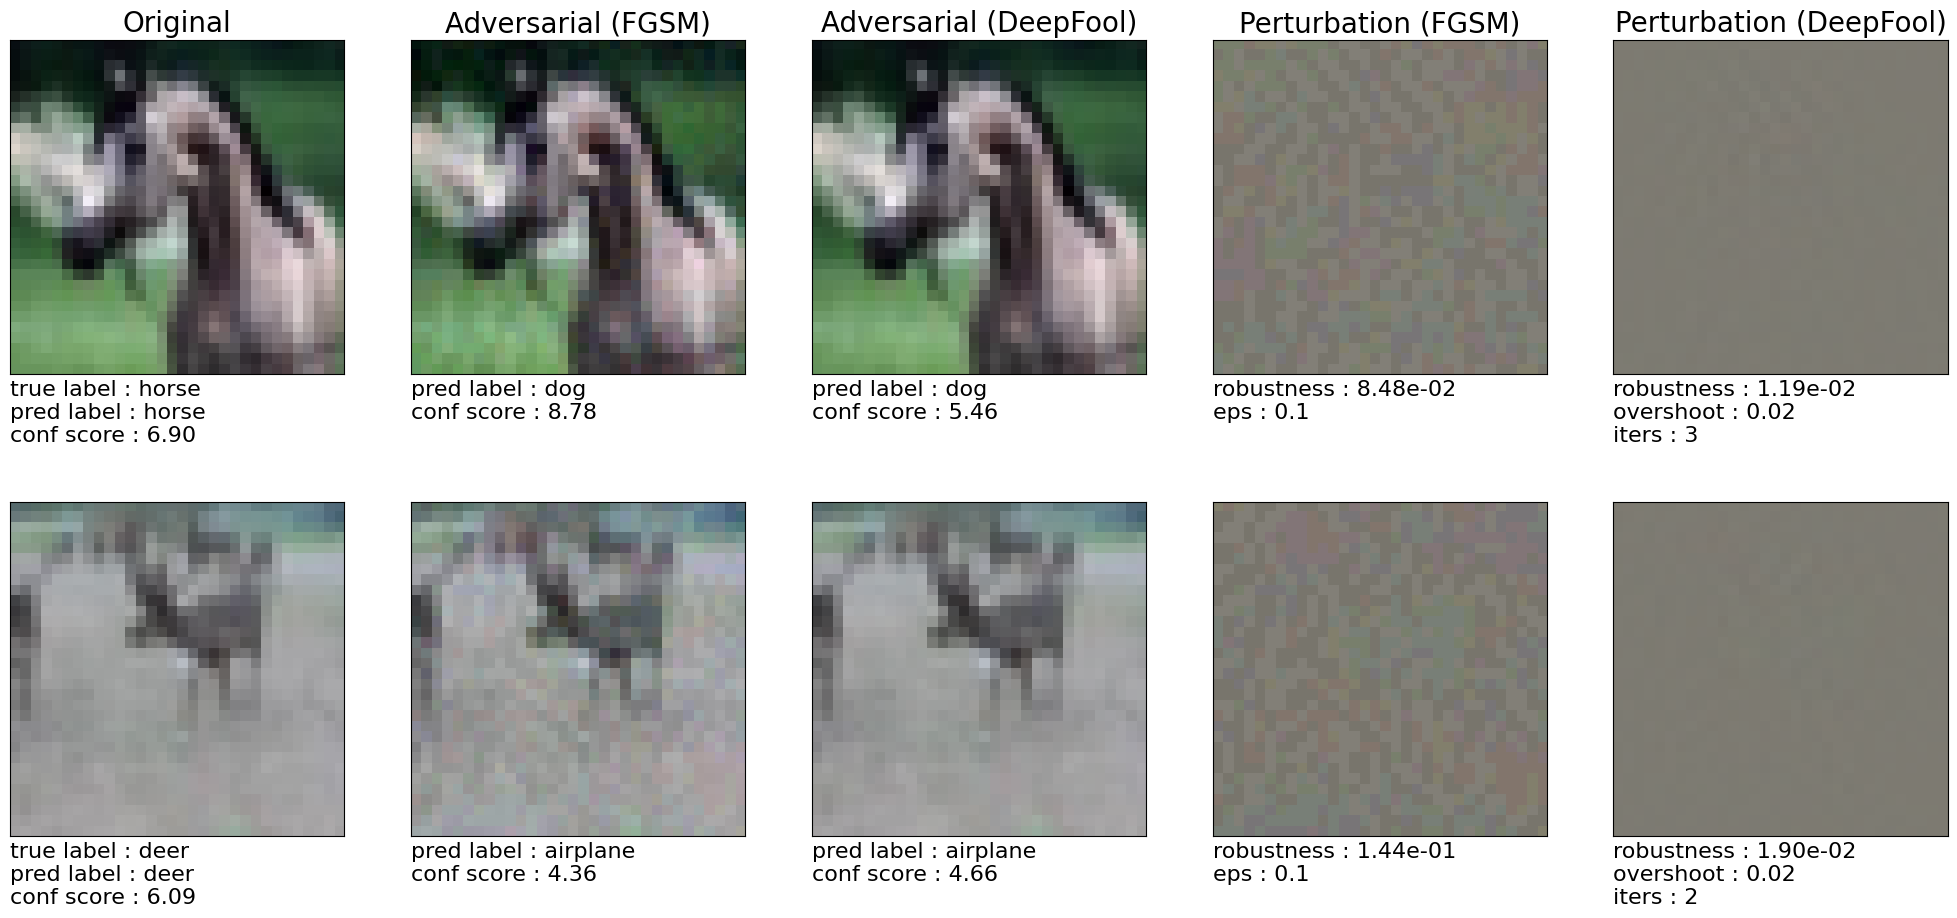

In [24]:
# LeNet на CIFAR
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


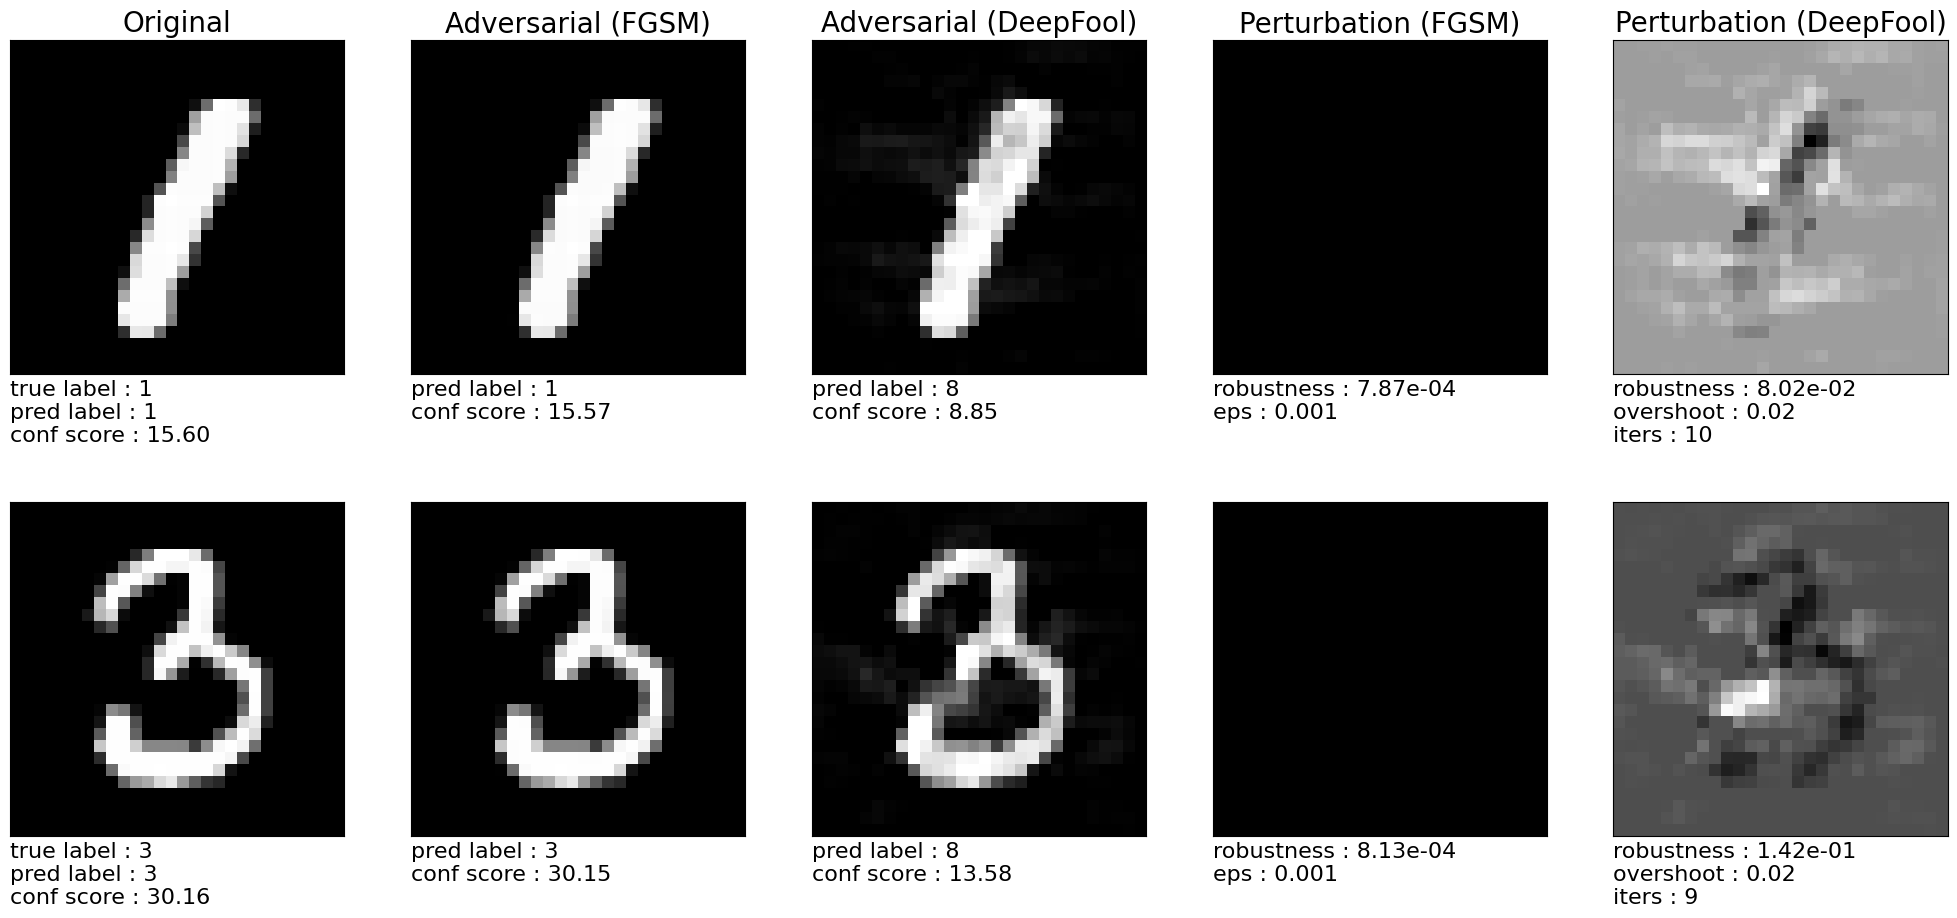

eps:  0.001


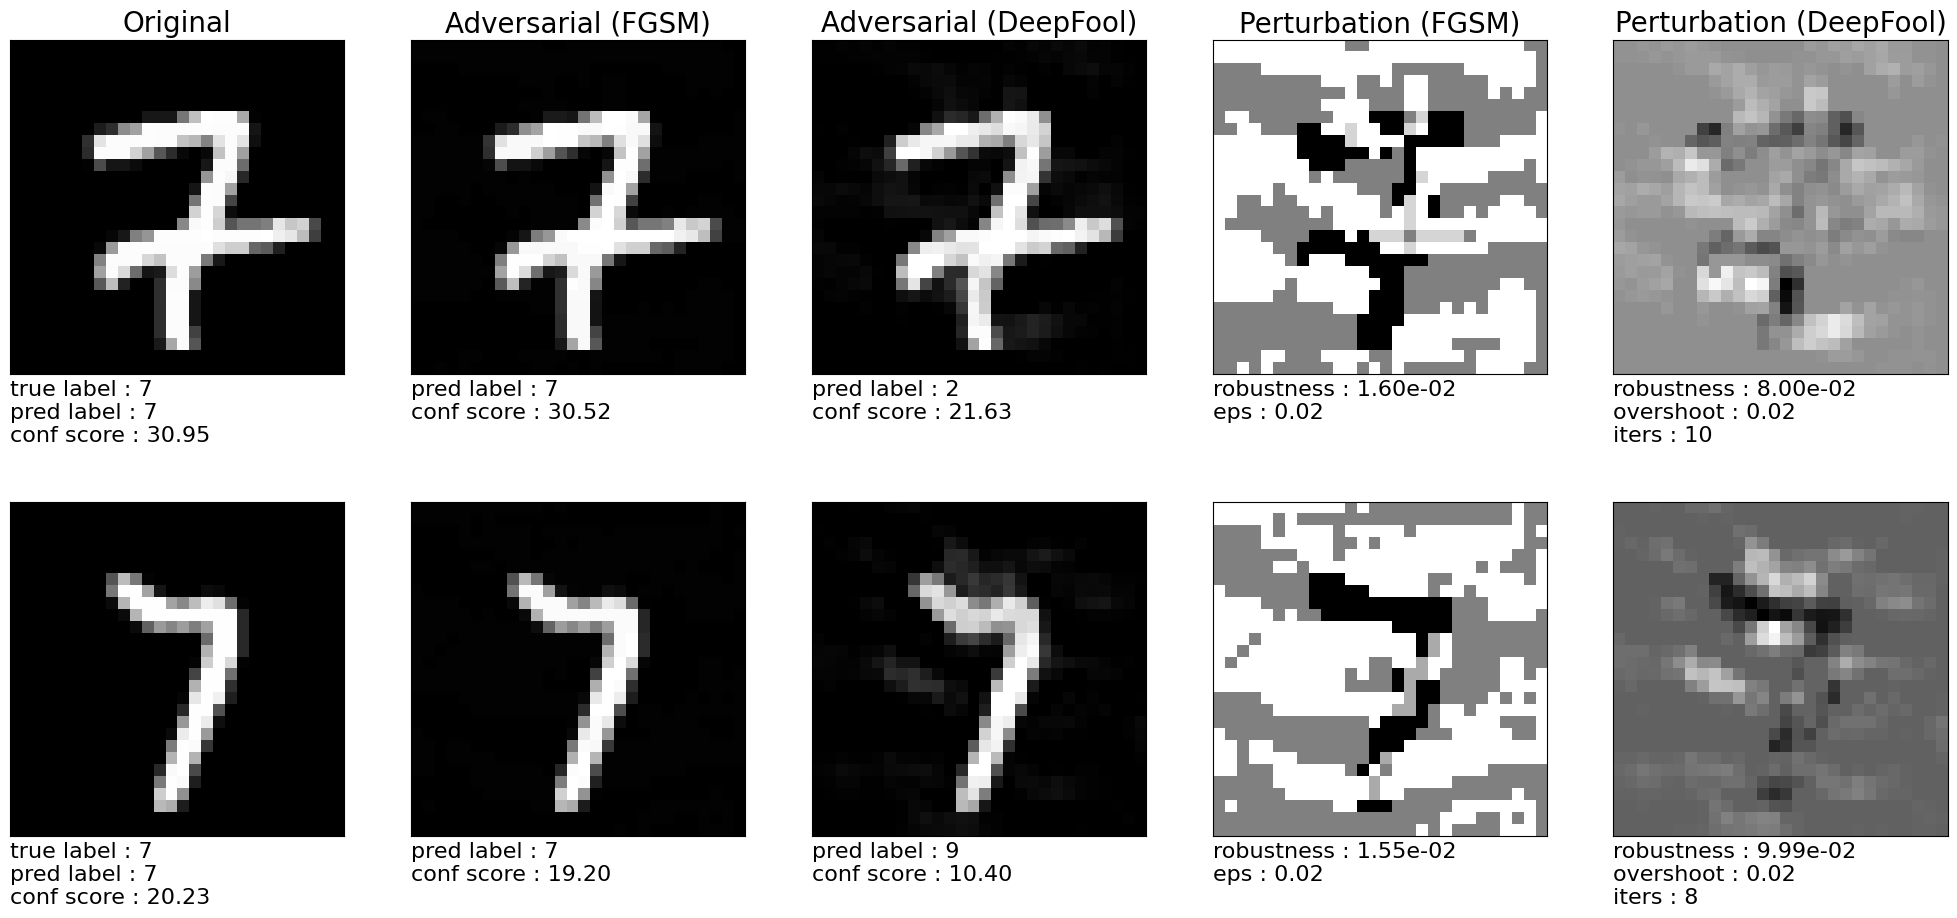

eps:  0.02


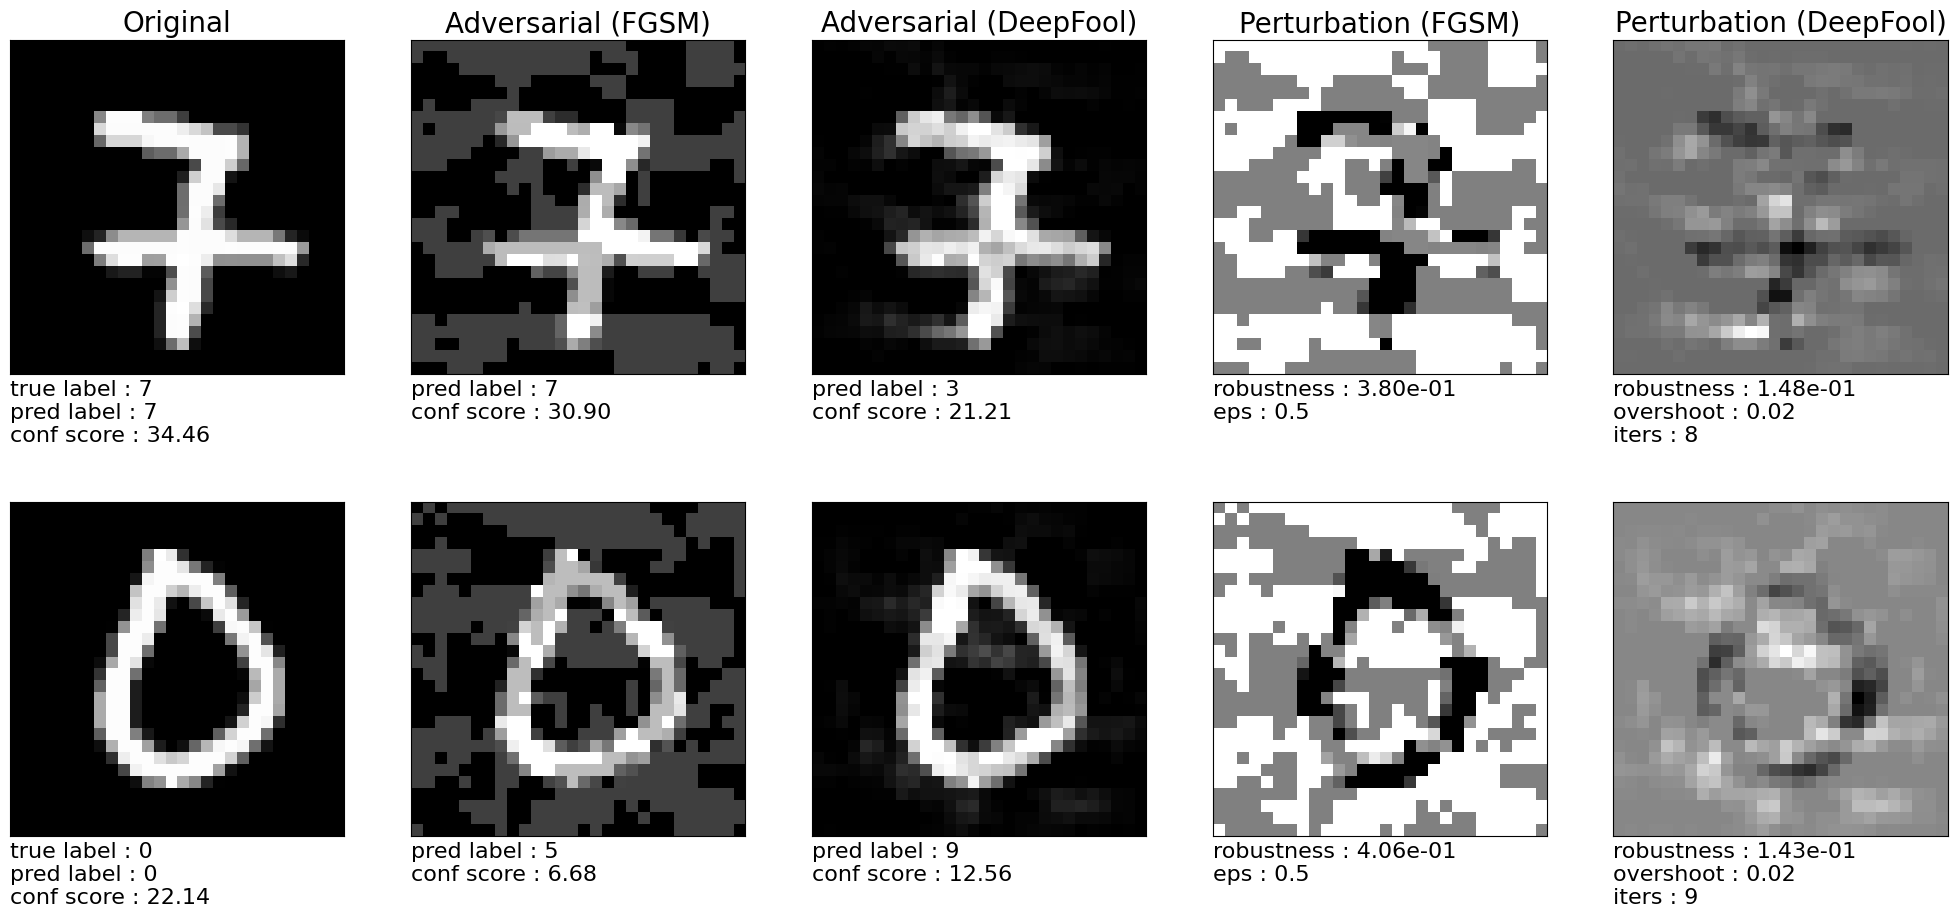

eps:  0.5


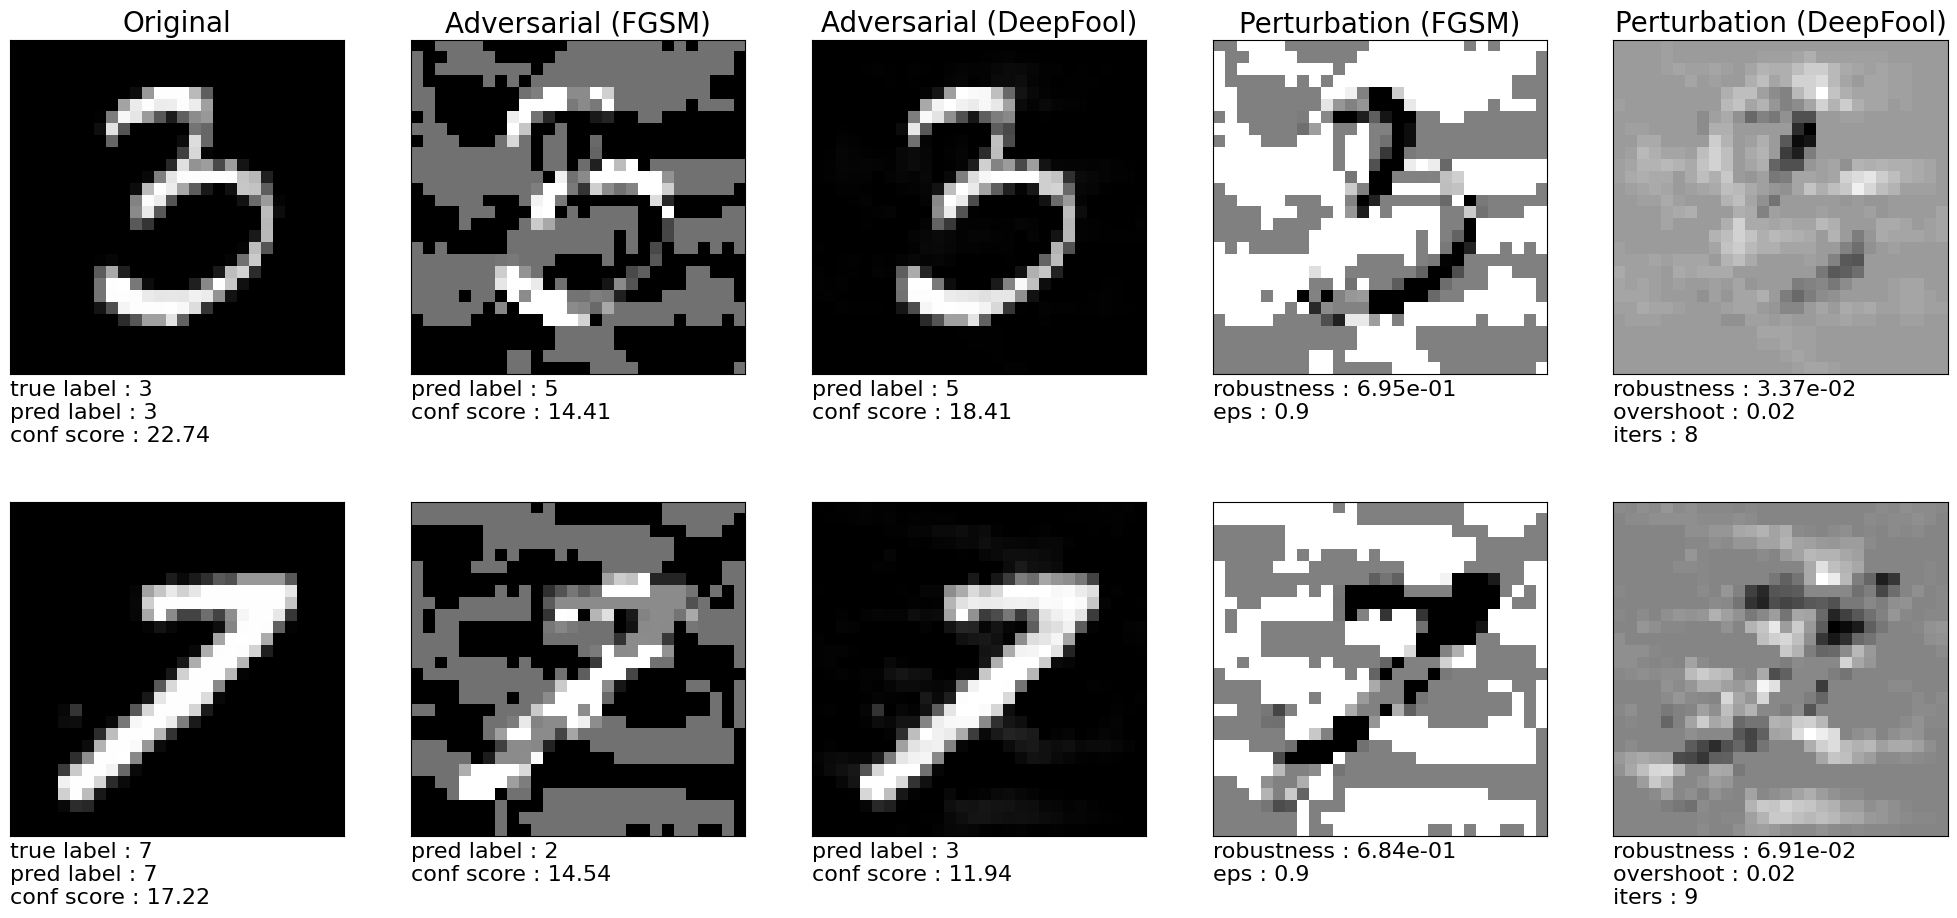

eps:  0.9


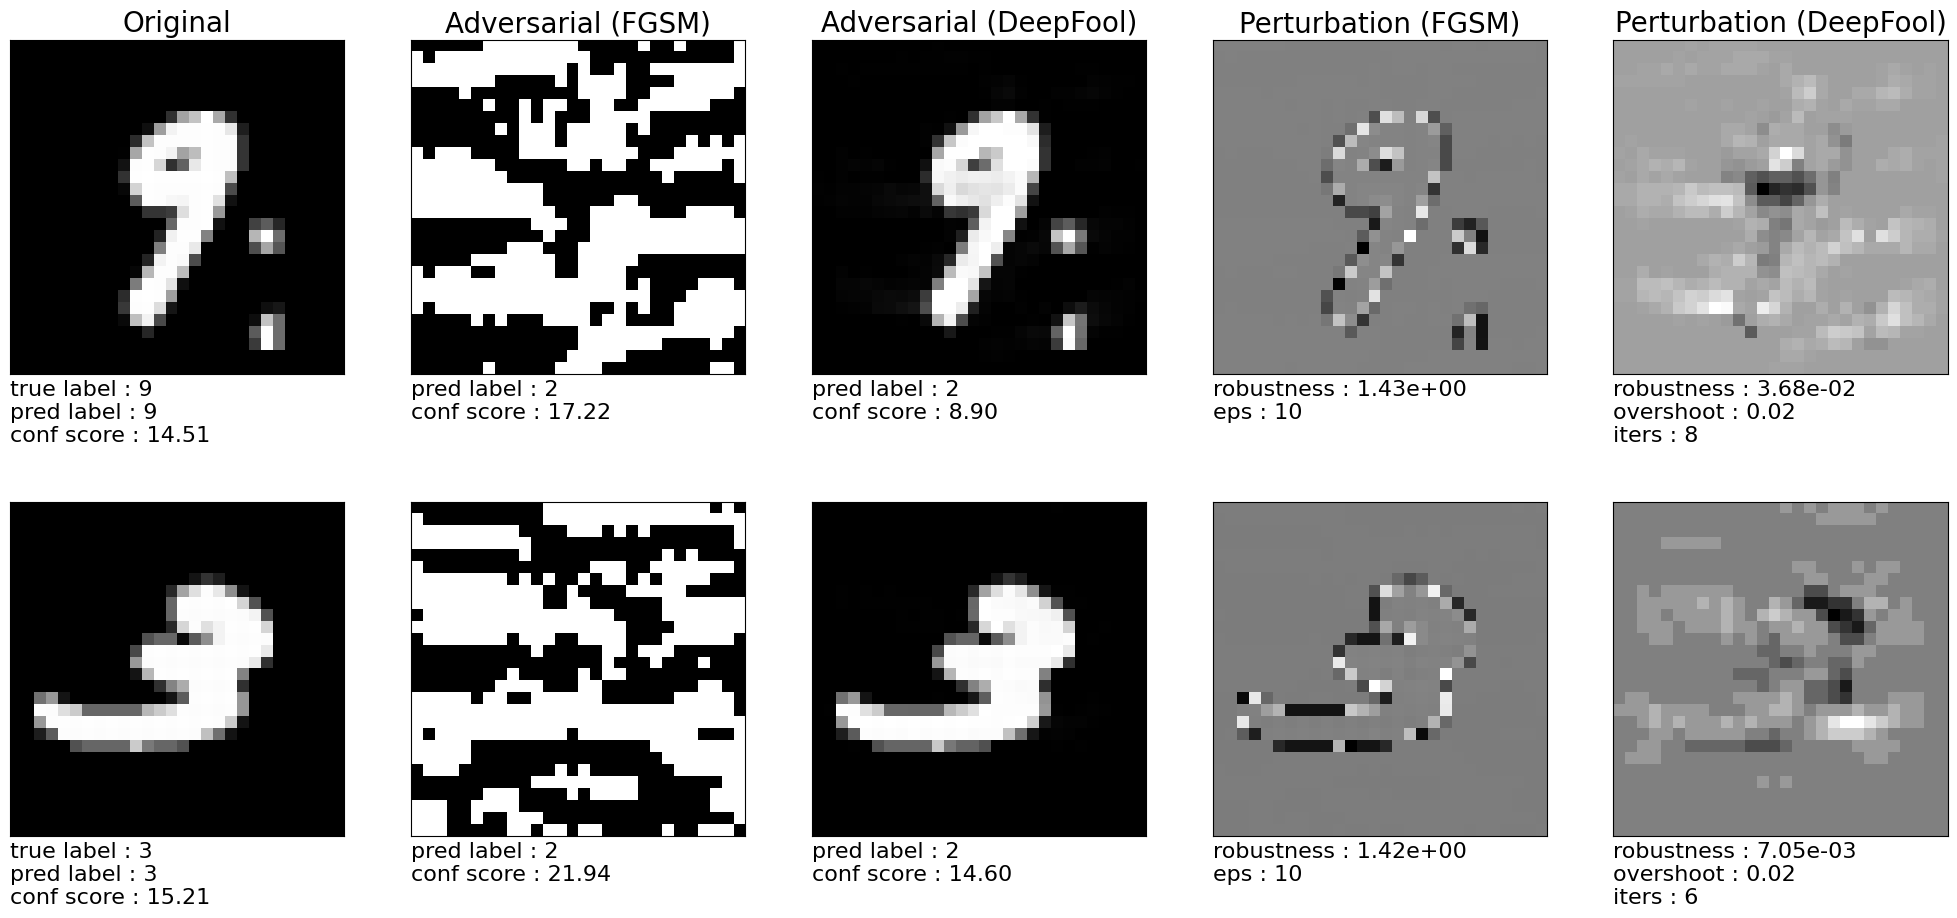

eps:  10


In [26]:
# Отразим отличия для fgsm_eps=(0.001, 0.02, 0.5, 0.9, 10)
fgsm_eps_arr = [0.001, 0.02, 0.5, 0.9, 10]

for fgsm_eps in fgsm_eps_arr:
  model = LeNet_MNIST().to(device)
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

  if device.type == 'cuda': torch.cuda.empty_cache()
  print("eps: ", fgsm_eps)

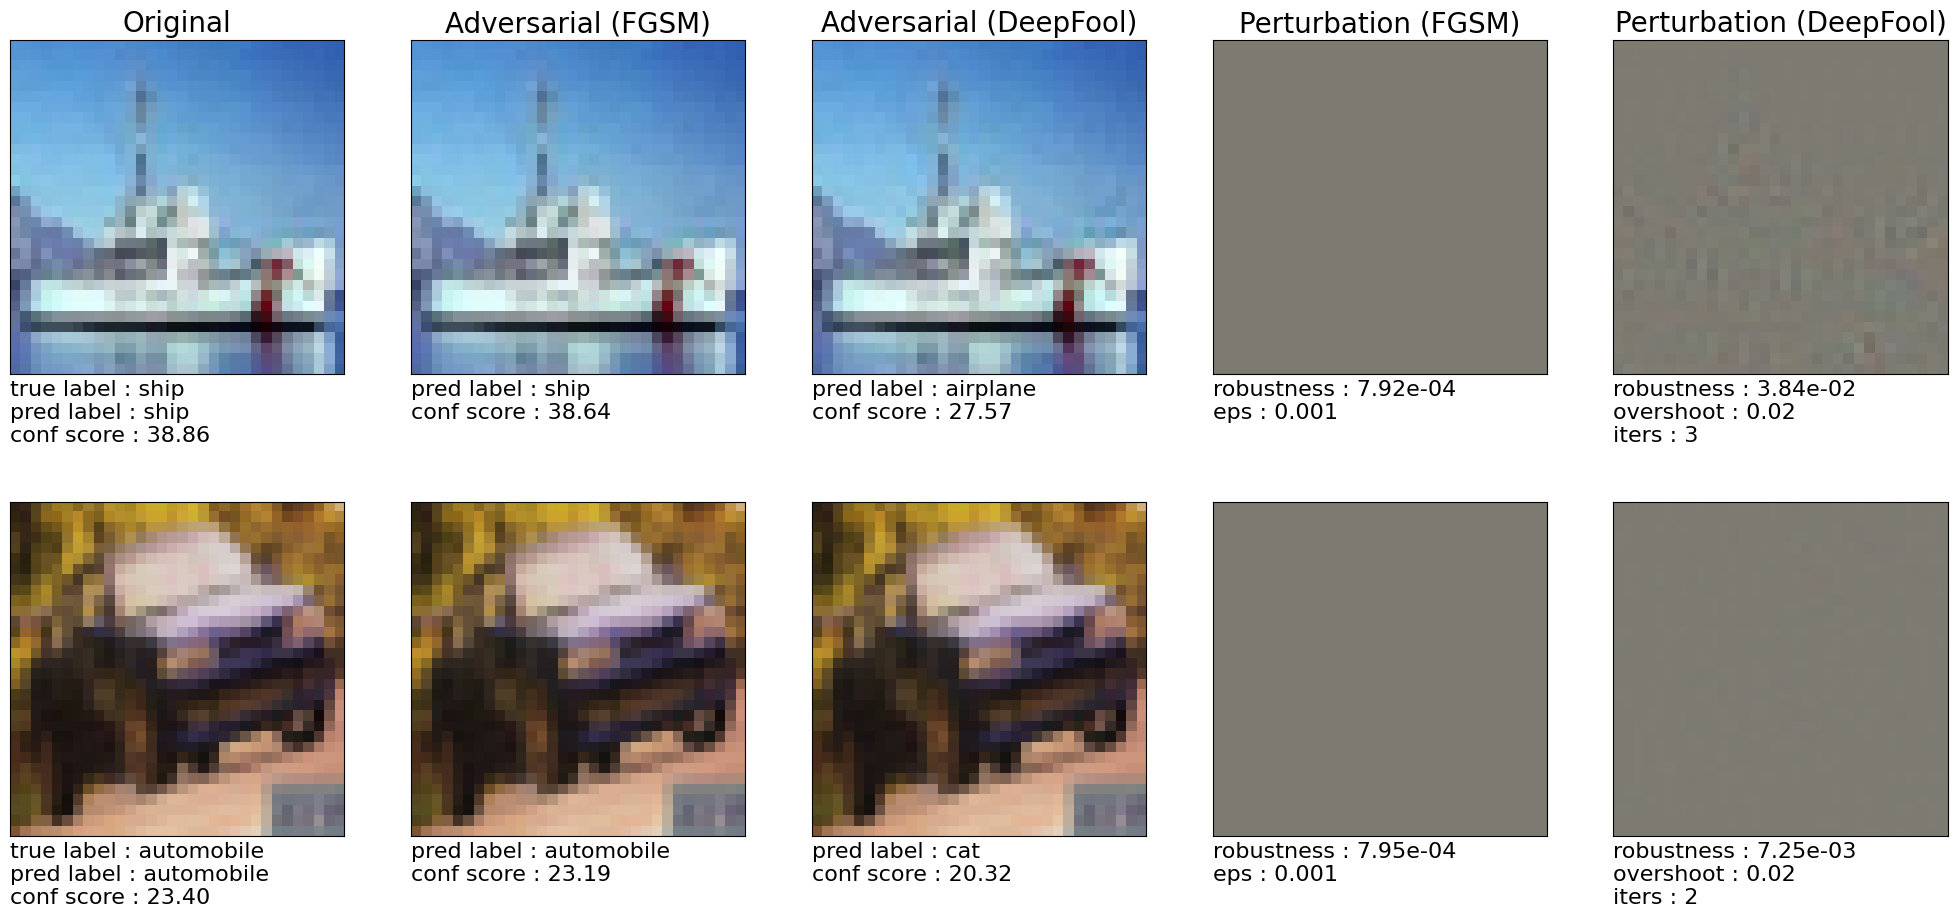

eps:  0.001


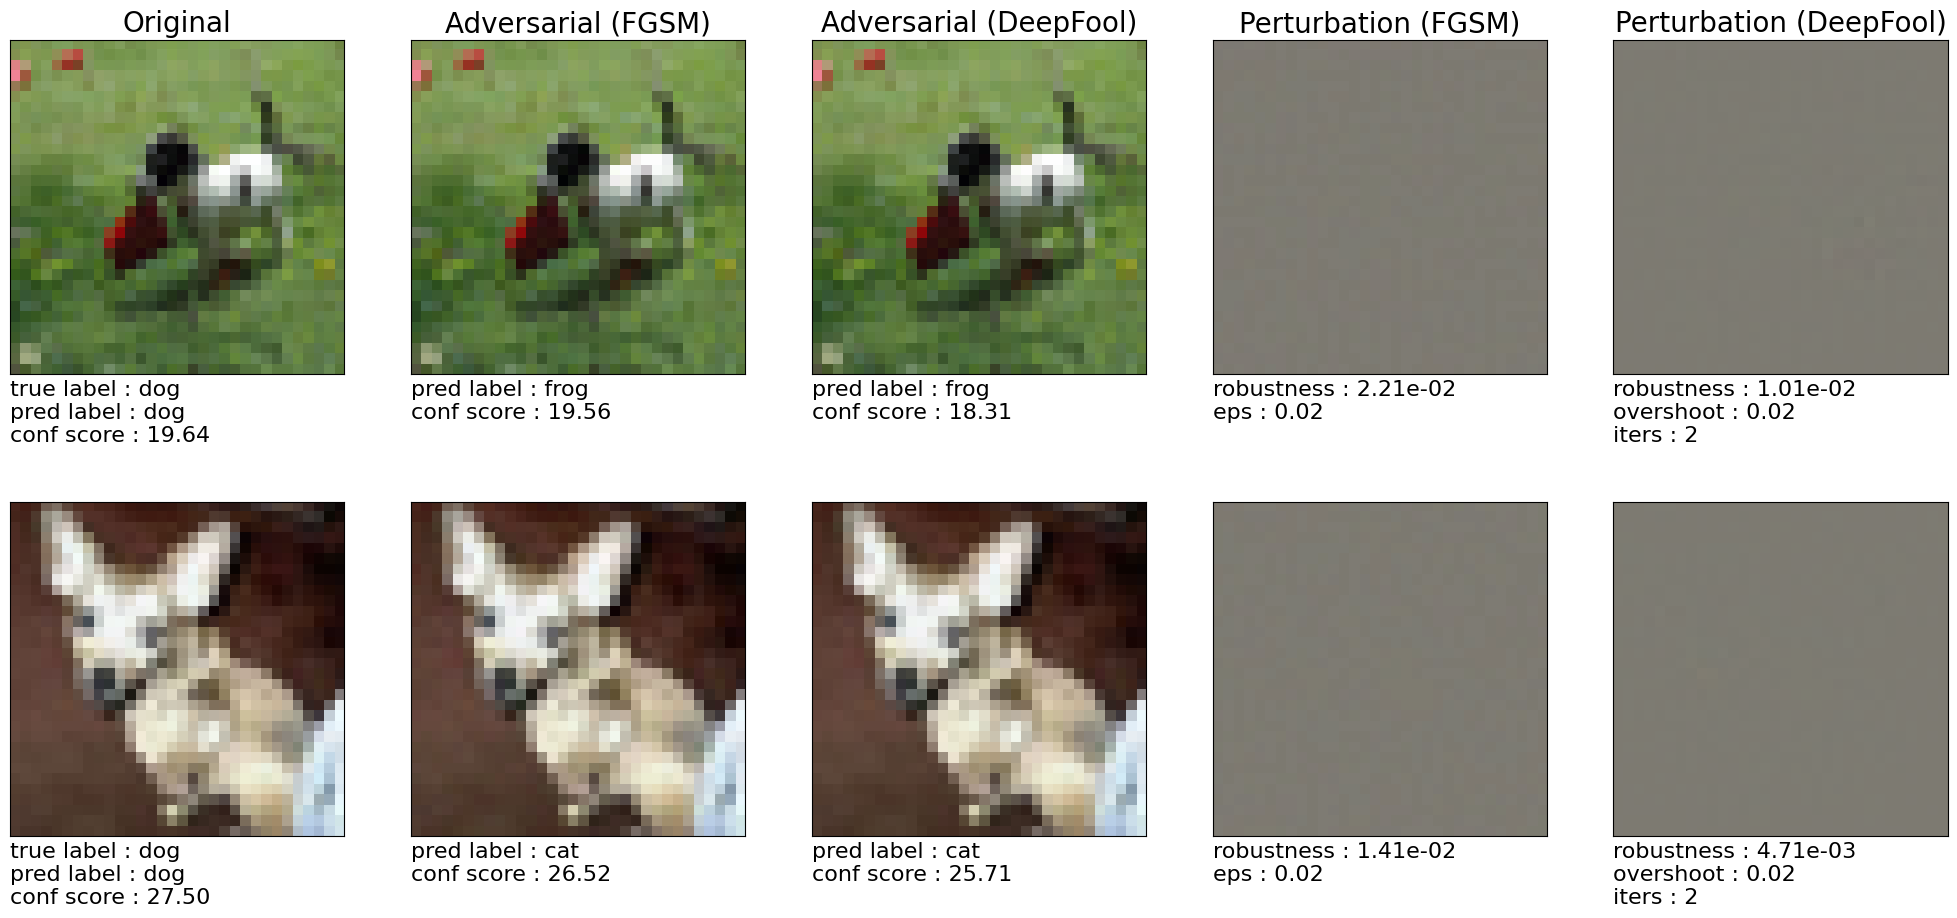

eps:  0.02


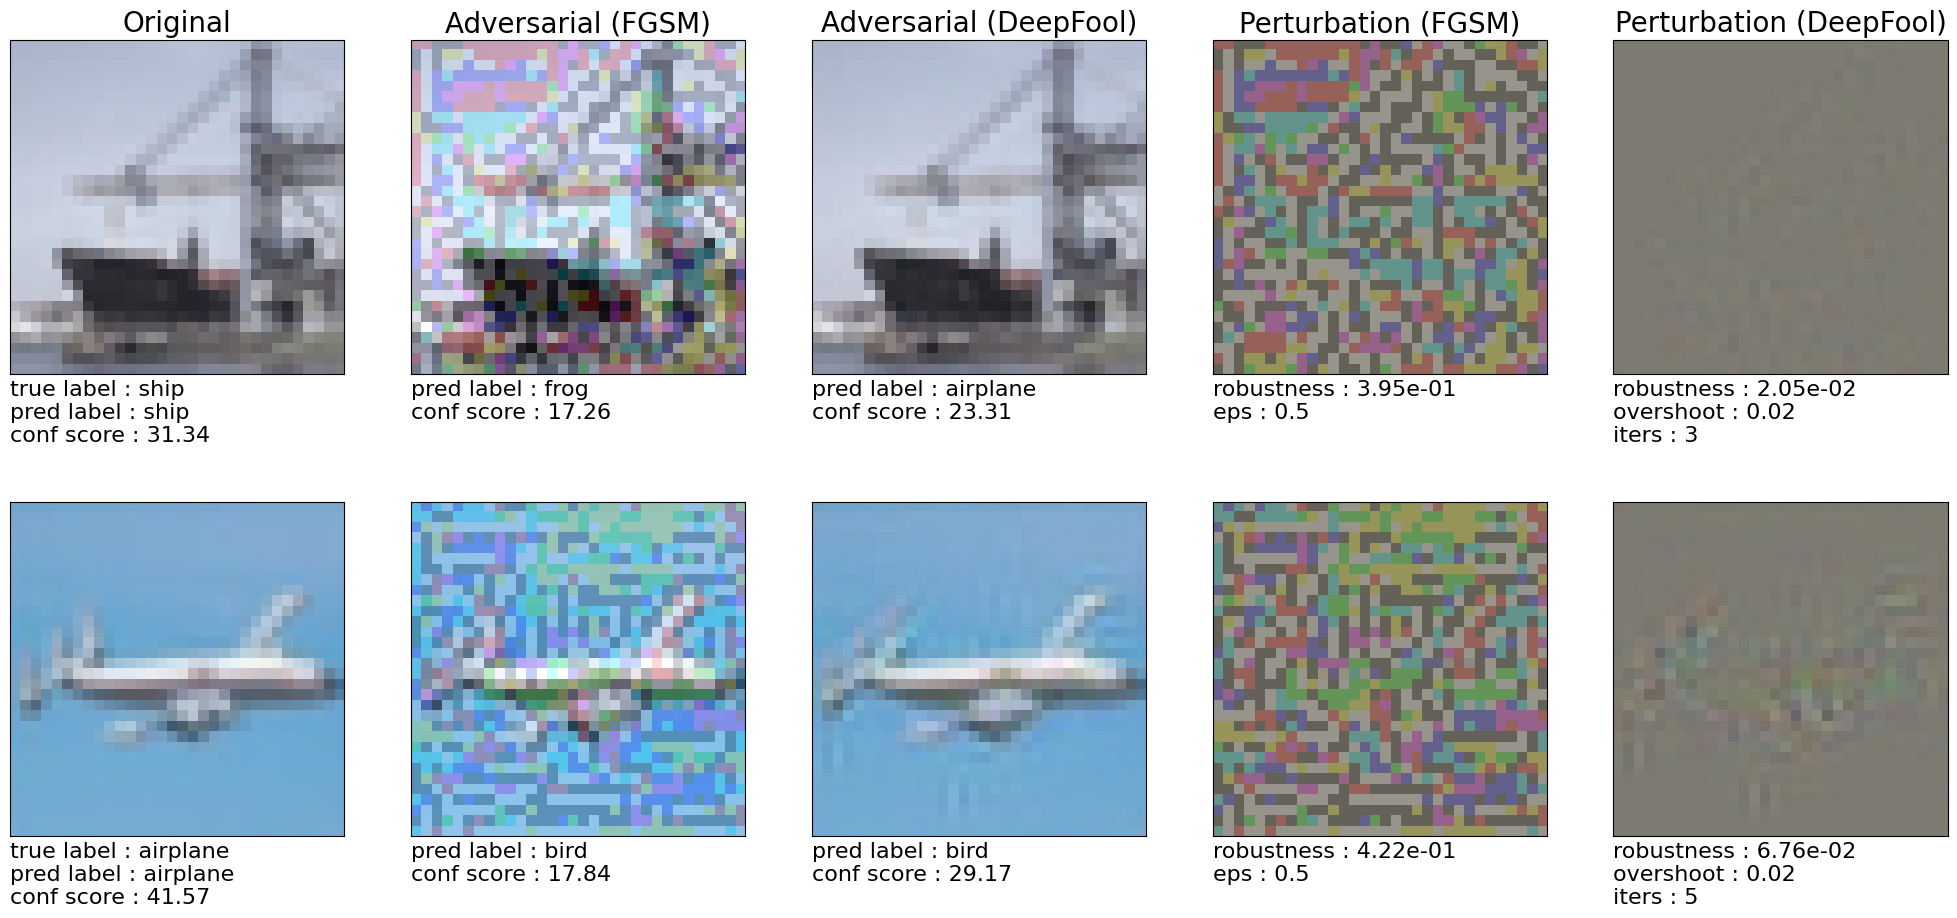

eps:  0.5


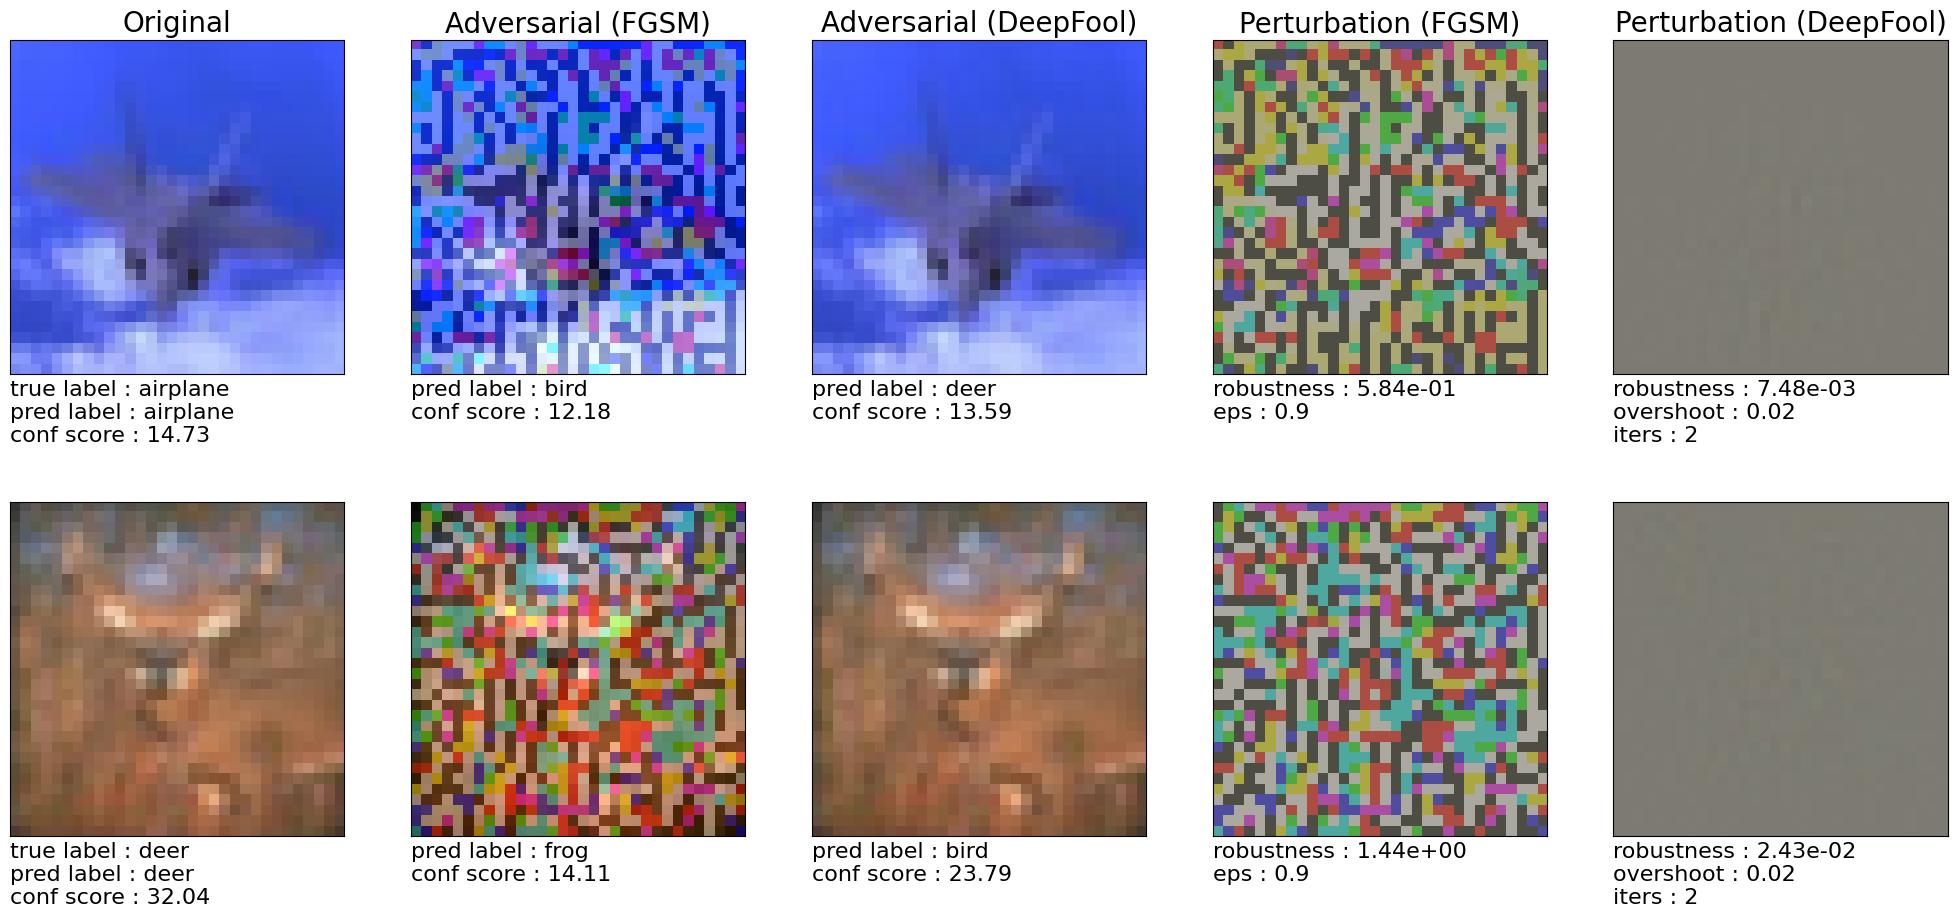

eps:  0.9


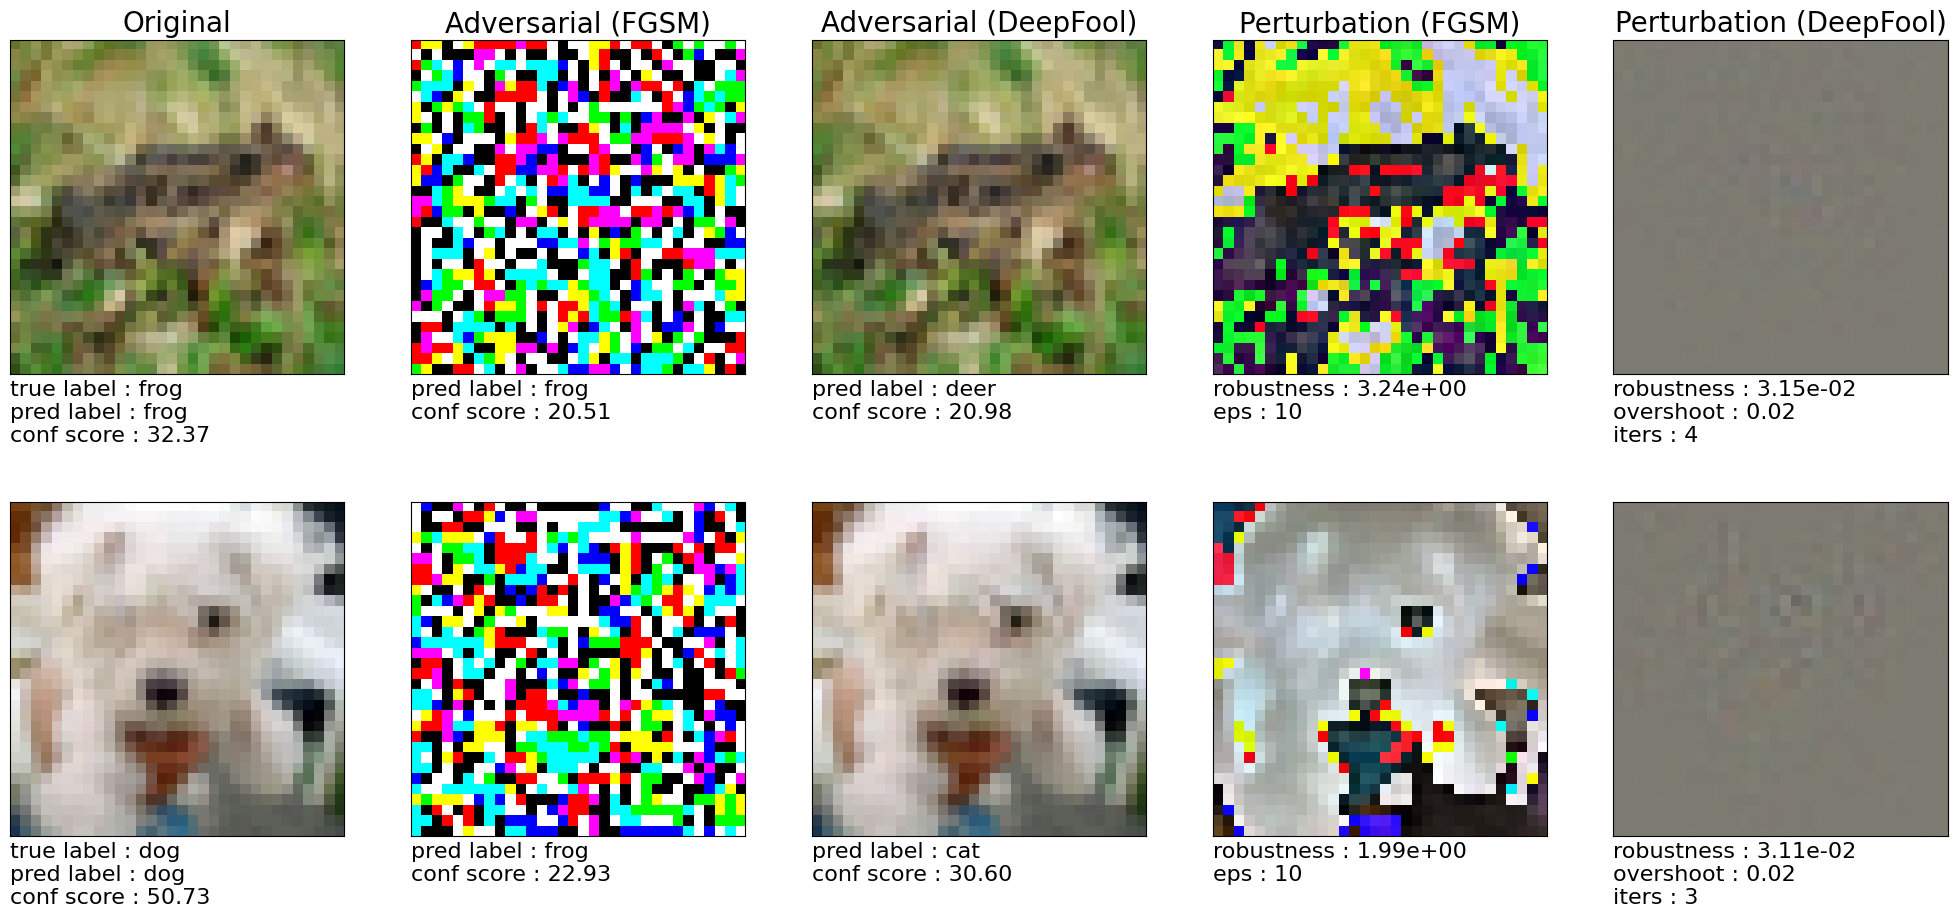

eps:  10


In [27]:
for fgsm_eps in fgsm_eps_arr:
  model = Net().to(device)
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

  display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

  if device.type == 'cuda': torch.cuda.empty_cache()
  print("eps: ", fgsm_eps)

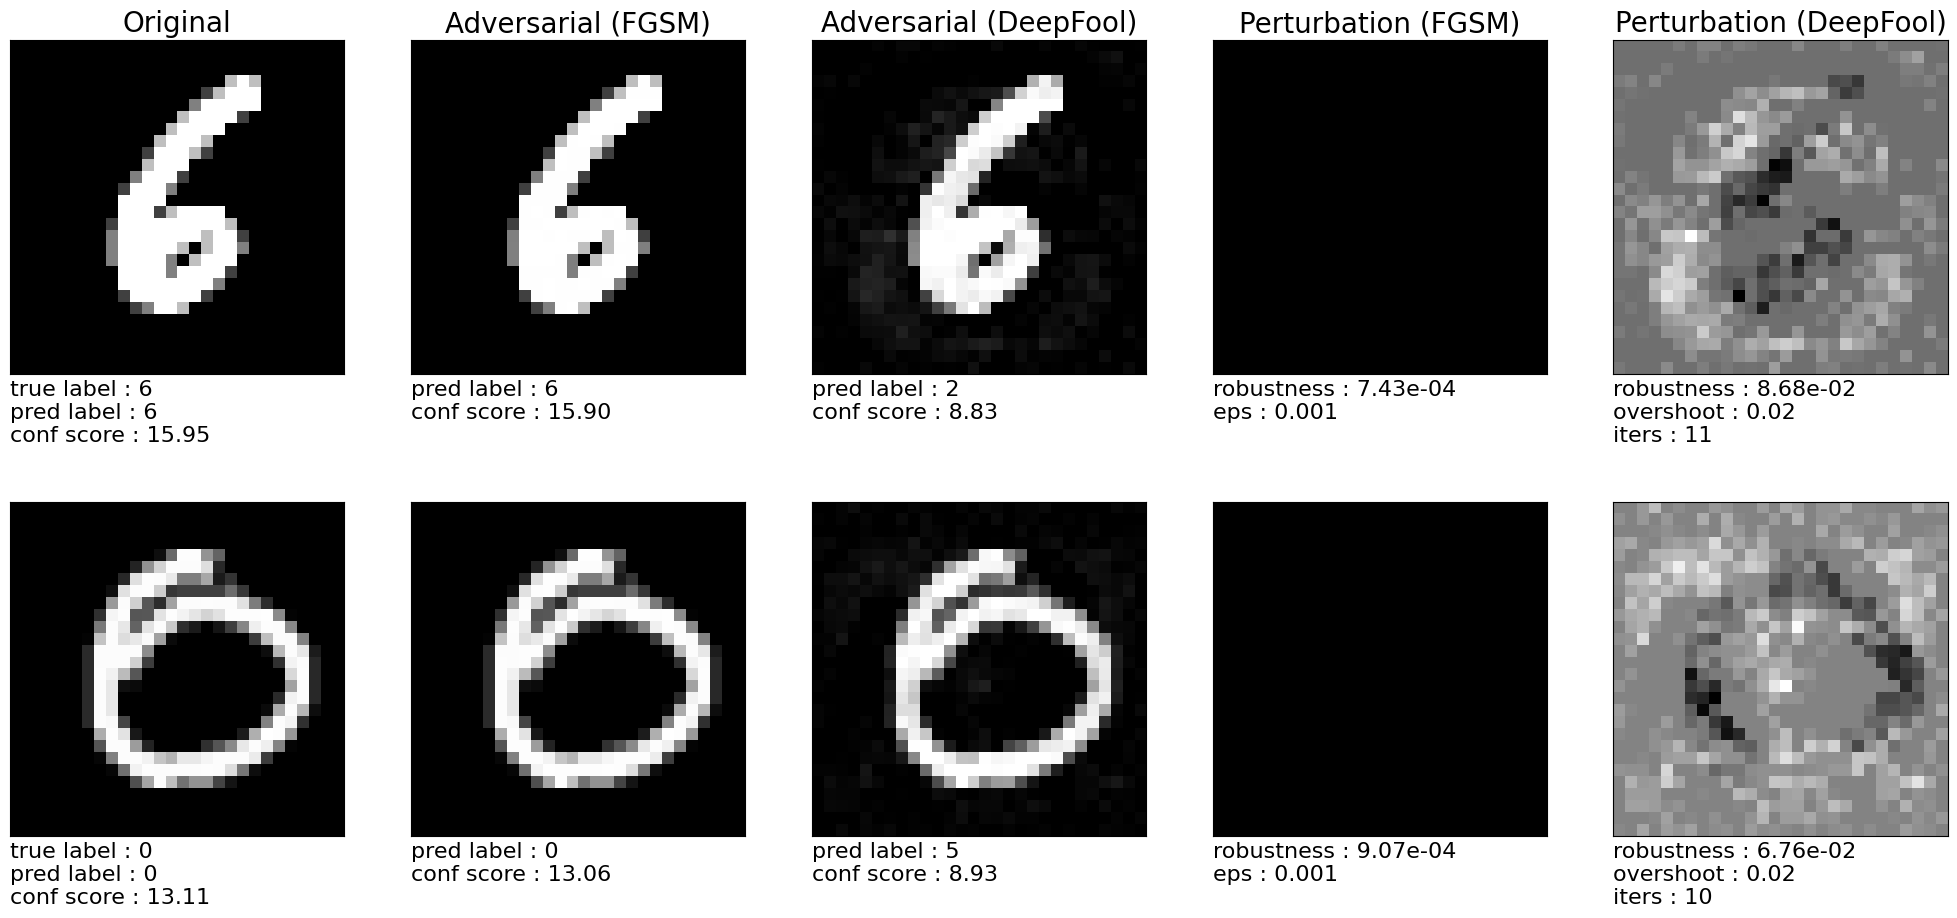

eps:  0.001


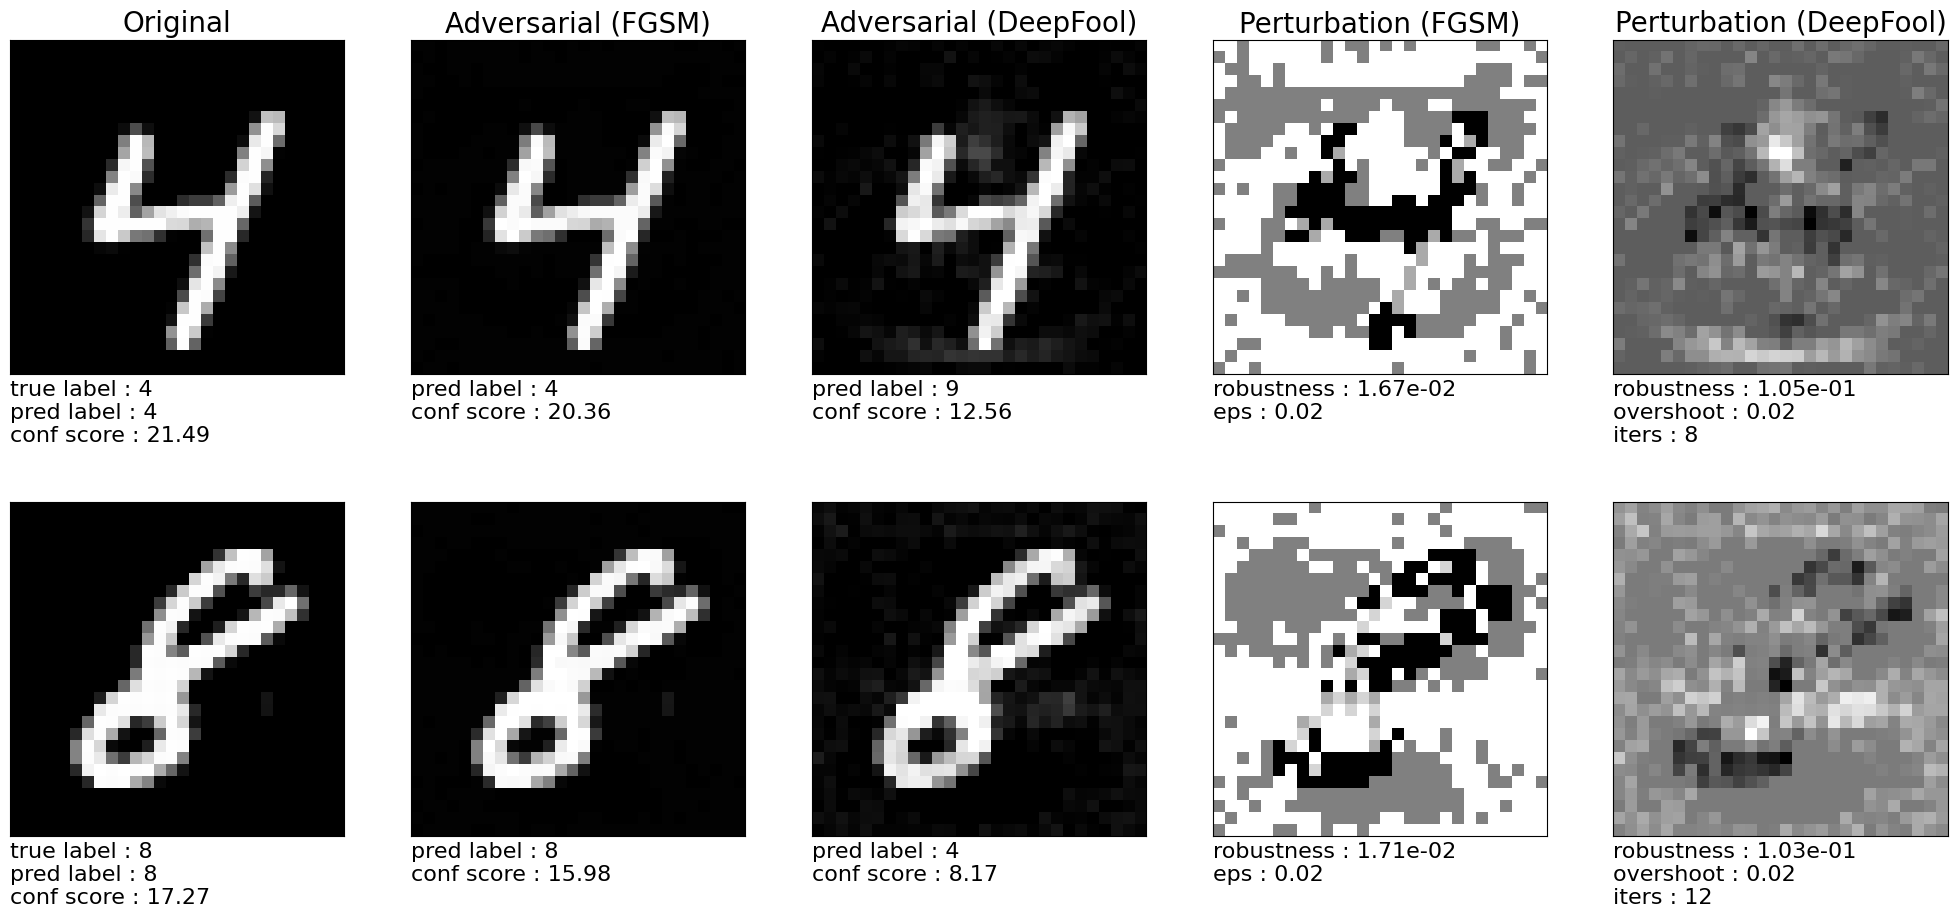

eps:  0.02


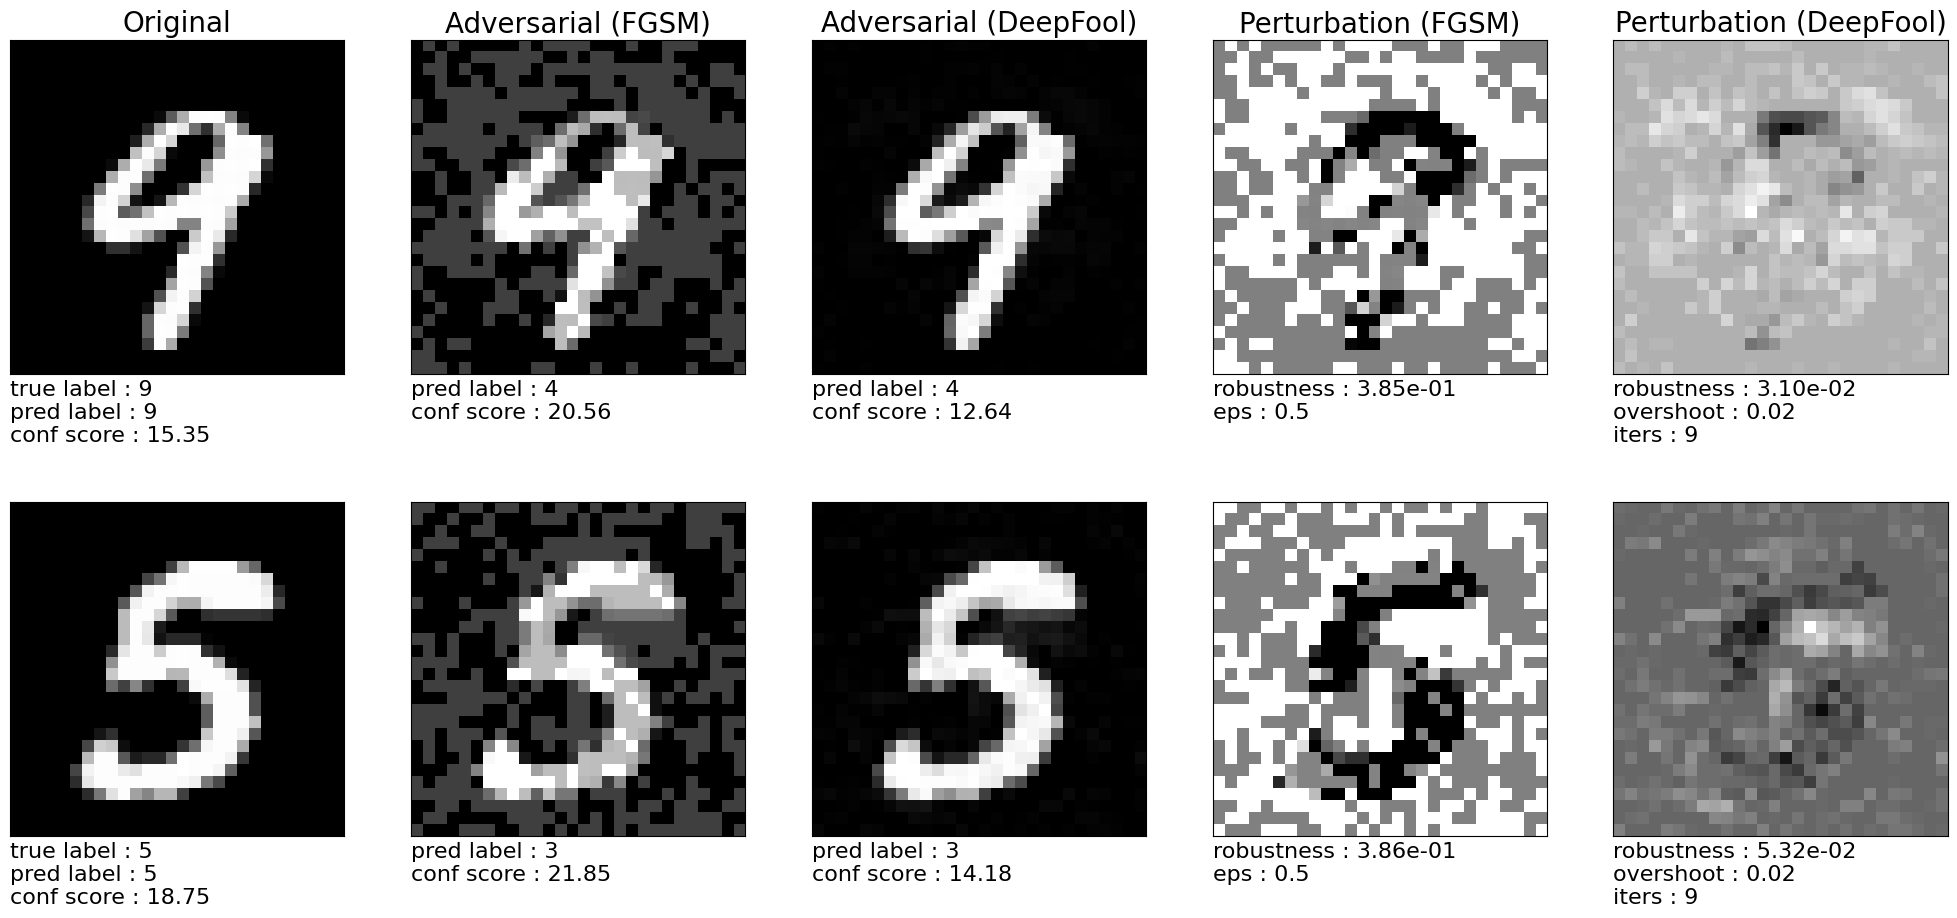

eps:  0.5


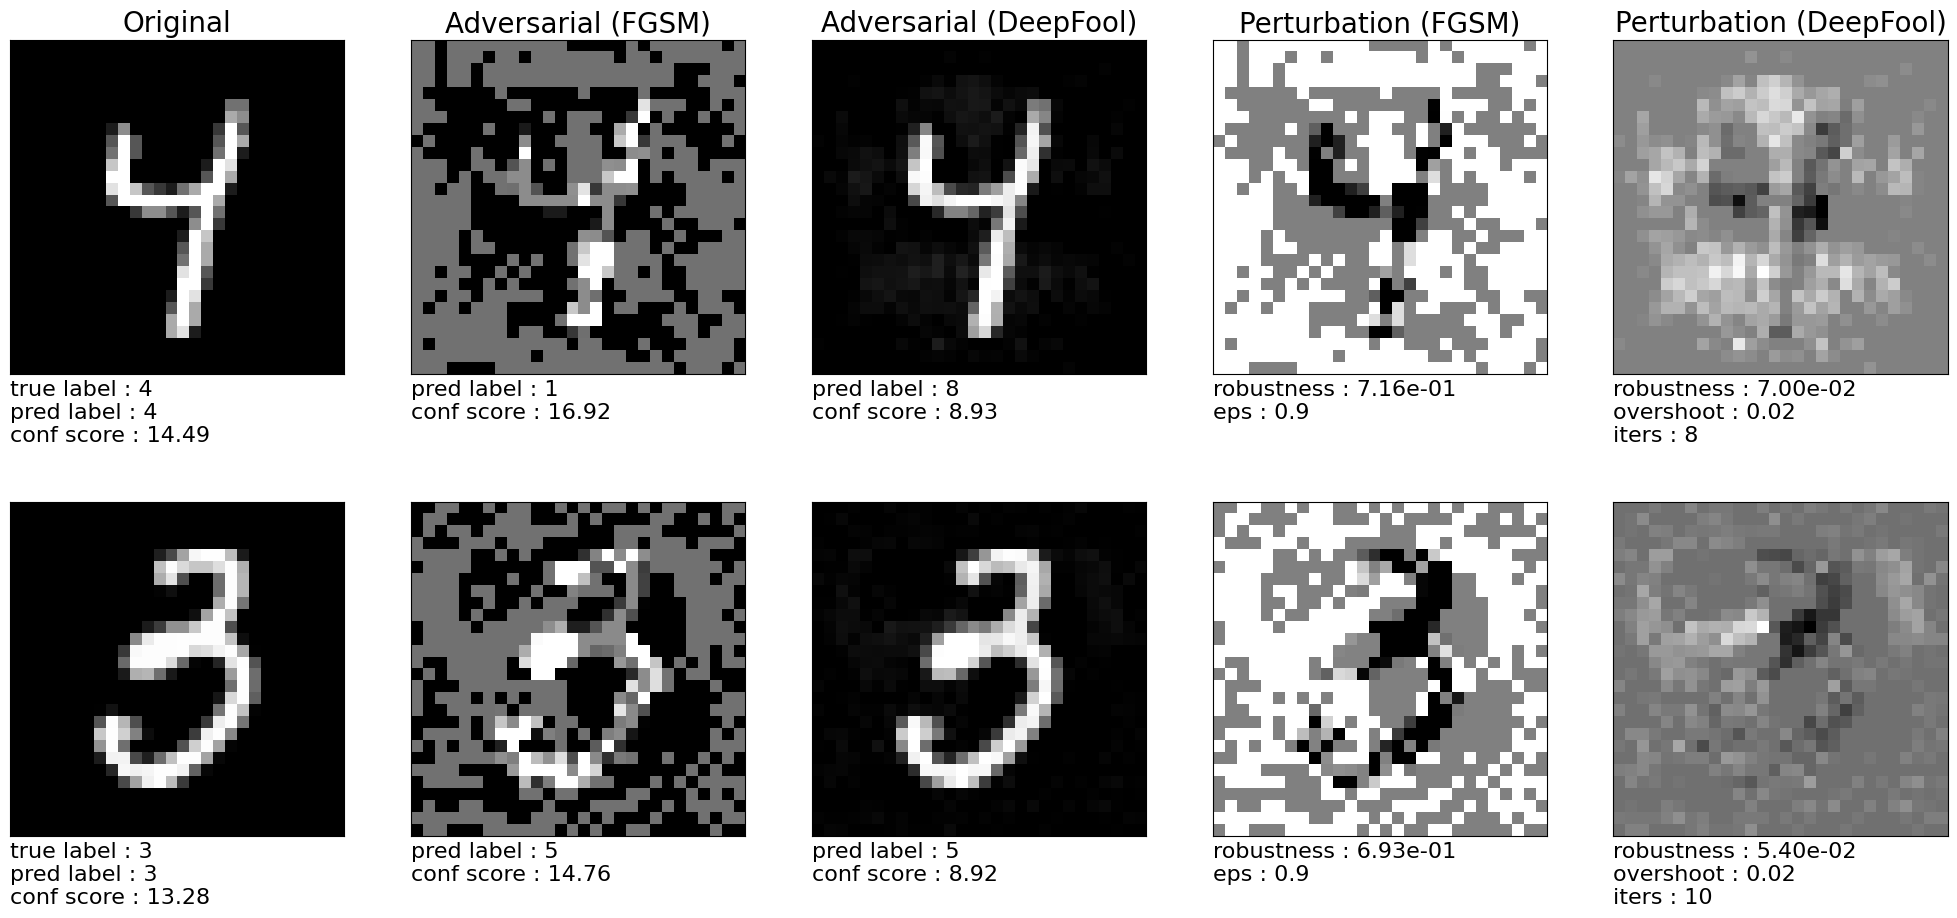

eps:  0.9


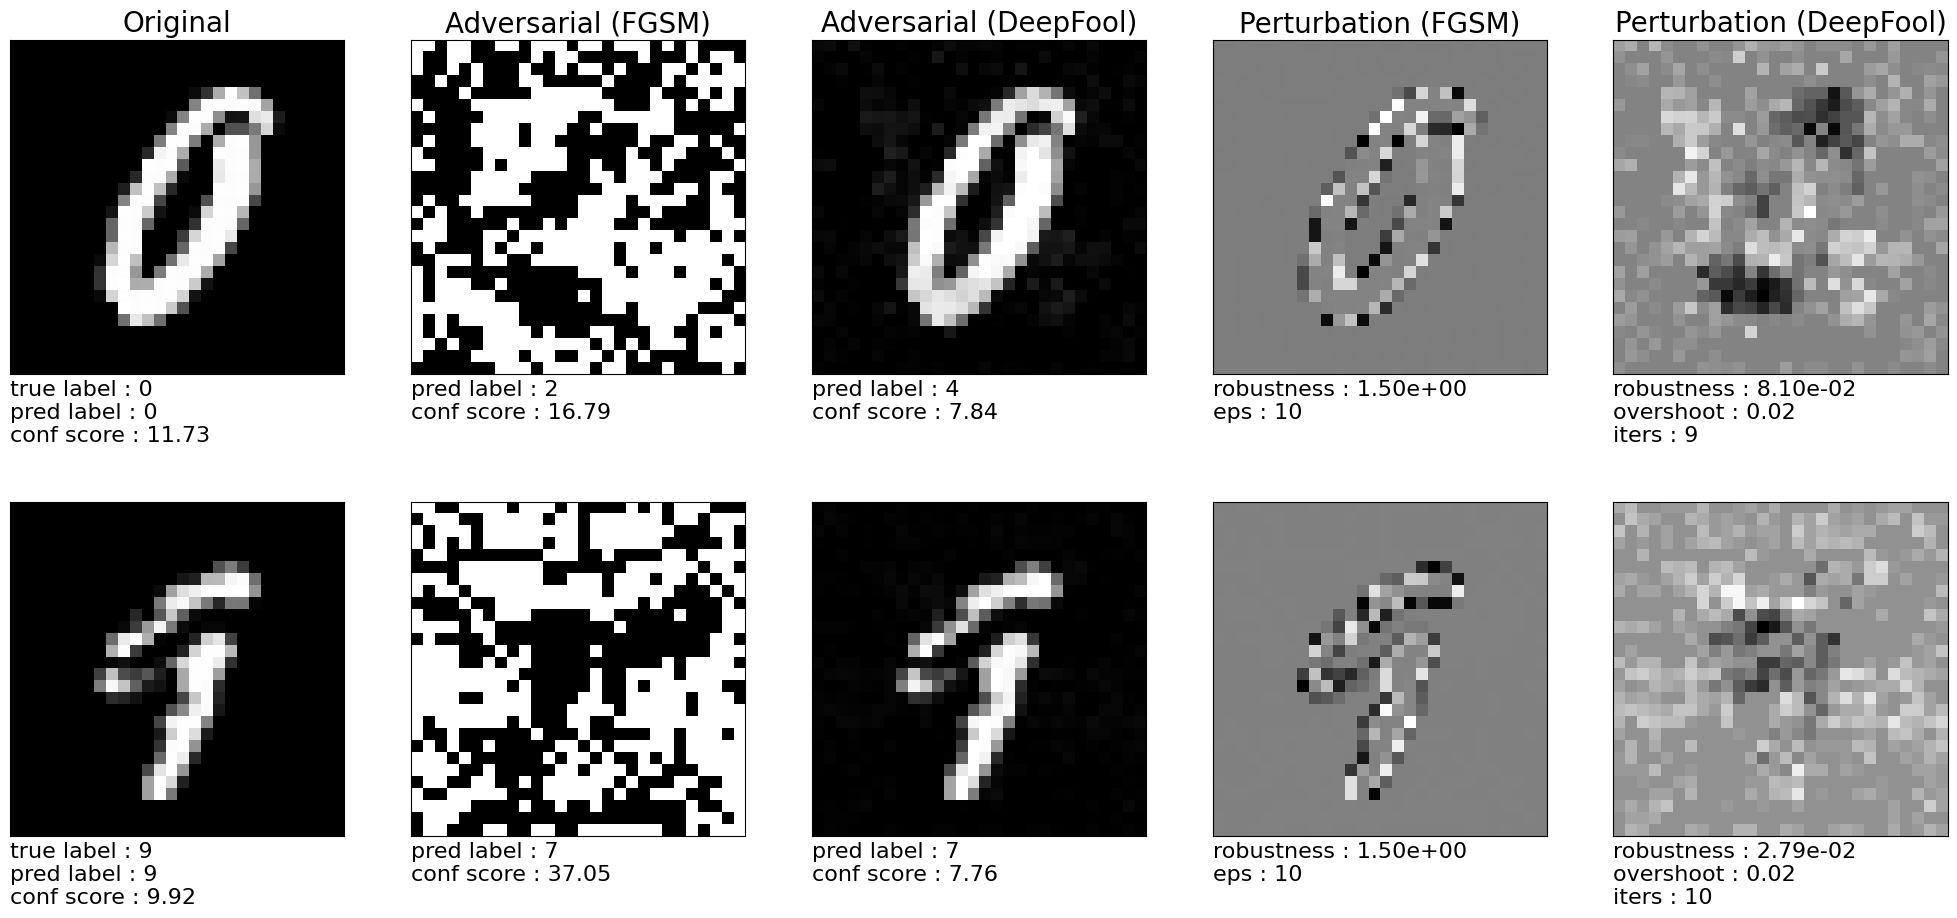

eps:  10


In [28]:
for fgsm_eps in fgsm_eps_arr:
  model = FC_500_150().to(device)
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

  if device.type == 'cuda': torch.cuda.empty_cache()
  print("eps: ", fgsm_eps)